# RoBERTa Fine-tuning - 3-Class Emotion Classification


## Import Libraries


In [1]:
import pandas as pd
import numpy as np
import json
import os
import warnings
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
os.makedirs("../models/roberta_emotion_model_3class", exist_ok=True)
os.makedirs("../results/models", exist_ok=True)
os.makedirs("../results/figures", exist_ok=True)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch version: 2.9.1
CUDA available: False


## Load Data (3-Class Balanced Dataset)


In [2]:
train_df = pd.read_csv("../data/processed/train_processed_3class.csv")
val_df = pd.read_csv("../data/processed/val_processed_3class.csv")
test_df = pd.read_csv("../data/processed/test_processed_3class.csv")

print(f"Train: {train_df.shape} | Val: {val_df.shape} | Test: {test_df.shape}")
print("\nClass distribution (already balanced):")
print(train_df['emotion'].value_counts().sort_index())


Train: (43362, 2) | Val: (5421, 2) | Test: (5421, 2)

Class distribution (already balanced):
emotion
negative    14454
neutral     14454
positive    14454
Name: count, dtype: int64


## Load Emotion Mapping (3 Classes)


In [3]:
with open("../data/processed/emotion_mapping_3class.json", "r") as f:
    emotion_mapping = json.load(f)

id_to_emotion = {int(k): v for k, v in emotion_mapping["id_to_emotion"].items()}
emotion_to_id = emotion_mapping["emotion_to_id"]
num_labels = len(emotion_to_id)

print(f"Number of classes: {num_labels}")
print("Emotion to ID mapping:")
for emotion, idx in emotion_to_id.items():
    print(f"  {emotion}: {idx}")


Number of classes: 3
Emotion to ID mapping:
  negative: 0
  neutral: 1
  positive: 2


## Prepare Data


In [4]:
X_train = train_df["text"].values
y_train = train_df["emotion"].map(emotion_to_id).values

X_val = val_df["text"].values
y_val = val_df["emotion"].map(emotion_to_id).values

X_test = test_df["text"].values
y_test = test_df["emotion"].map(emotion_to_id).values

print(f"Train: {len(X_train)} samples")
print(f"Val: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")


Train: 43362 samples
Val: 5421 samples
Test: 5421 samples


## Initialize Model


In [5]:
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

print(f"Model: {model_name}")
print(f"Number of parameters: {model.num_parameters():,}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: roberta-base
Number of parameters: 124,647,939


## Dataset Class


In [6]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }


## Create Datasets


In [7]:
train_dataset = EmotionDataset(X_train, y_train, tokenizer)
val_dataset = EmotionDataset(X_val, y_val, tokenizer)
test_dataset = EmotionDataset(X_test, y_test, tokenizer)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")


Train dataset: 43362 samples
Val dataset: 5421 samples
Test dataset: 5421 samples


## Metrics Function


In [8]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    f1 = f1_score(labels, predictions, average="weighted")
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


## Training Configuration


In [31]:
training_args = TrainingArguments(
    output_dir="../models/roberta_emotion_model_3class/checkpoints",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    warmup_steps=1000,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    logging_dir="../models/roberta_emotion_model_3class/logs",
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=5,
    seed=42,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

print("Training arguments configured:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  LR scheduler: {training_args.lr_scheduler_type}")
print(f"  FP16: {training_args.fp16}")
print(f"  Eval strategy: {training_args.eval_strategy}")
print(f"  Eval steps: {training_args.eval_steps}")
print(f"  Save strategy: {training_args.save_strategy}")
print(f"  Save steps: {training_args.save_steps}")
print(f"  Save total limit: {training_args.save_total_limit}")


Training arguments configured:
  Epochs: 4
  Batch size: 16
  Learning rate: 2e-05
  LR scheduler: SchedulerType.COSINE
  FP16: False
  Eval strategy: IntervalStrategy.STEPS
  Eval steps: 500
  Save strategy: SaveStrategy.STEPS
  Save steps: 500
  Save total limit: 5


## Initialize Trainer


In [32]:
required_imports = ['Trainer', 'TrainingArguments', 'EarlyStoppingCallback']
missing_imports = [imp for imp in required_imports if imp not in globals()]
if missing_imports:
    raise ImportError(
        f"Missing required imports: {', '.join(missing_imports)}\n"
        f"Please run Cell 2 (Import Libraries) first to load all required modules."
    )

required_vars = ['model', 'training_args', 'train_dataset', 'val_dataset', 'compute_metrics']
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    raise NameError(
        f"Missing required variables: {', '.join(missing_vars)}\n"
        f"Please run the previous cells in order."
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
)

print("Trainer initialized successfully")


Trainer initialized successfully


## Train Model


In [33]:
try:
    _ = trainer
except NameError:
    raise NameError("Trainer not initialized. Please run Cell 20 first to initialize the trainer.")

checkpoint_dir = "../models/roberta_emotion_model_3class/checkpoints"
resume_from_checkpoint = None

def is_checkpoint_complete(checkpoint_path):
    required_files = [
        "trainer_state.json",
        "model.safetensors",
        "optimizer.pt",
        "scheduler.pt",
        "rng_state.pth"
    ]
    return all(os.path.exists(os.path.join(checkpoint_path, f)) for f in required_files)

if os.path.exists(checkpoint_dir):
    checkpoints = [d for d in os.listdir(checkpoint_dir) if d.startswith("checkpoint-")]
    if checkpoints:
        checkpoints.sort(key=lambda x: int(x.split("-")[1]), reverse=True)
        
        complete_checkpoint = None
        incomplete_checkpoints = []
        
        for checkpoint_name in checkpoints:
            checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
            if is_checkpoint_complete(checkpoint_path):
                if complete_checkpoint is None:
                    complete_checkpoint = checkpoint_path
                    print(f"Found complete checkpoint: {checkpoint_name}")
            else:
                incomplete_checkpoints.append(checkpoint_name)
        
        if complete_checkpoint:
            resume_from_checkpoint = complete_checkpoint
            import json
            with open(os.path.join(complete_checkpoint, "trainer_state.json"), "r") as f:
                state = json.load(f)
            epoch = state.get("epoch", 0)
            step = state.get("global_step", 0)
            print(f"   Current progress: Epoch {epoch:.2f}, Step {step}")
            print(f"   Resuming training from this checkpoint...")
        else:
            print("No complete checkpoints found. Starting fresh training...")
        
        if incomplete_checkpoints:
            print(f"\nFound {len(incomplete_checkpoints)} incomplete checkpoint(s): {', '.join(incomplete_checkpoints)}")
            print("   These will be ignored. Consider cleaning them up if training completes successfully.")
    else:
        print("No checkpoints found. Starting fresh training...")
else:
    print("No checkpoint directory found. Starting fresh training...")

print("\nStarting training...")
try:
    trainer.train(resume_from_checkpoint=resume_from_checkpoint)
    print("\nTraining completed successfully!")
except KeyboardInterrupt:
    print("\nTraining interrupted by user. Progress has been saved to checkpoints.")
    raise
except Exception as e:
    print(f"\nTraining failed with error: {str(e)}")
    print("   You can resume from the last complete checkpoint by running this cell again.")
    raise


Found complete checkpoint: checkpoint-10000
   Current progress: Epoch 3.69, Step 10000
   Resuming training from this checkpoint...

Starting training...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
10500,0.206100,0.968850,0.732891,0.733910,0.732891,0.733320



Training completed successfully!


## Save Model


In [34]:
model_save_path = "../models/roberta_emotion_model_3class"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to: {model_save_path}")


Model saved to: ../models/roberta_emotion_model_3class


## Test Evaluation


In [35]:
test_results = trainer.evaluate(test_dataset)

print("Test Set Performance:")
print(f"  Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"  Precision: {test_results['eval_precision']:.4f}")
print(f"  Recall: {test_results['eval_recall']:.4f}")
print(f"  F1-Score: {test_results['eval_f1']:.4f}")


Test Set Performance:
  Accuracy: 0.7464
  Precision: 0.7441
  Recall: 0.7464
  F1-Score: 0.7439


## Generate Predictions


In [36]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

print(f"Predictions shape: {y_pred.shape}")
print(f"True labels shape: {y_test.shape}")


Predictions shape: (5421,)
True labels shape: (5421,)


## Classification Report


In [37]:
emotion_names = [id_to_emotion[i] for i in range(num_labels)]

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=emotion_names))


Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.81      0.78      1807
     neutral       0.70      0.62      0.66      1807
    positive       0.78      0.81      0.80      1807

    accuracy                           0.75      5421
   macro avg       0.74      0.75      0.74      5421
weighted avg       0.74      0.75      0.74      5421



## Confusion Matrix


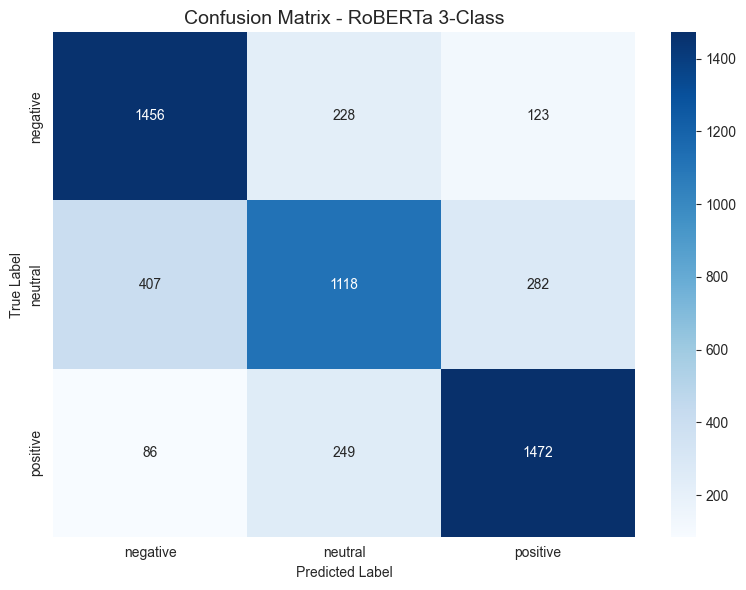

In [38]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=emotion_names,
            yticklabels=emotion_names)
plt.title("Confusion Matrix - RoBERTa 3-Class", fontsize=14)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig("../results/figures/confusion_matrix_roberta_3class.png", dpi=300, bbox_inches="tight")
plt.show()


## Save Results


In [39]:
roberta_results = {
    "accuracy": test_results["eval_accuracy"],
    "precision": test_results["eval_precision"],
    "recall": test_results["eval_recall"],
    "f1": test_results["eval_f1"]
}

results_df = pd.DataFrame([roberta_results], index=["RoBERTa-3Class"])
results_df = results_df.round(4)

print("RoBERTa 3-Class Performance on Test Set:")
print(results_df)

results_df.to_csv("../results/models/roberta_results_3class.csv")
print("\nResults saved to: ../results/models/roberta_results_3class.csv")


RoBERTa 3-Class Performance on Test Set:
                accuracy  precision  recall      f1
RoBERTa-3Class    0.7464     0.7441  0.7464  0.7439

Results saved to: ../results/models/roberta_results_3class.csv


## Summary


In [40]:
print("RoBERTa 3-Class Training Summary:")
print(f"  Model: roberta-base")
print(f"  Classes: {num_labels} (positive, negative, neutral)")
print(f"  Accuracy: {roberta_results['accuracy']:.4f}")
print(f"  F1-Score: {roberta_results['f1']:.4f}")
print(f"  Precision: {roberta_results['precision']:.4f}")
print(f"  Recall: {roberta_results['recall']:.4f}")
print(f"\nModel saved to: ../models/roberta_emotion_model_3class")


RoBERTa 3-Class Training Summary:
  Model: roberta-base
  Classes: 3 (positive, negative, neutral)
  Accuracy: 0.7464
  F1-Score: 0.7439
  Precision: 0.7441
  Recall: 0.7464

Model saved to: ../models/roberta_emotion_model_3class
